In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Make sure you are at the root directory of repo
project_root_name = "/content/drive/MyDrive/MechInterpCodeLLMs"

# # Find the project root directory
# def find_project_root(current_path, project_name):
#     while current_path != os.path.dirname(current_path):
#         if project_name in os.listdir(current_path):
#             return os.path.join(current_path, project_name)
#         current_path = os.path.dirname(current_path)
#     raise FileNotFoundError(f"Project root directory '{project_name}' not found.")

# # Get the path of the current notebook
# current_path = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
# project_root = find_project_root(current_path, project_root_name)

# Set the project root as the current working directory
os.chdir('/content/drive/MyDrive/MechInterpCodeLLMs')

In [ ]:
# Feel free to change above code, your current directory should look like this
# README.md  config.py  data/  experiments/  logs/  plots/  transformer_lens/
%ls

experiments/  README.md  transformer_lens/


In [ ]:
# This is a local version of transformer_lens, pip uninstall transformer_lens before reach here
!pip install einops datasets jaxtyping better_abc fancy_einsum wandb torchtyping
!pip install matplotlib
import transformer_lens


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cach

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
import os
import time
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional, Callable
from typing_extensions import Literal
from functools import partial
import copy
import itertools
import json

from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML, Markdown
from IPython import get_ipython

# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

In [ ]:
# THIS IS A LOCAL (MODIFIED) VERSION OF TRANSFORMER_LENS - UNINSTALL PIP/CONDA VERSION BEFORE USE!
import transformer_lens
import transformer_lens.utils as utils
import transformer_lens.patching as patching
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)

In [ ]:
# HuggingFace bookkeeping so that the home folder doesn't get filled up
# I have these in my .bashrc and .zshrc and they work in terminal but not recognized by python for some reason

# You dont these to run gpt2-small, if you dont want to mess with hf, just comment this

import os
from config import HF_TOKEN, HF_PATH

os.environ["HF_TOKEN"] = HF_TOKEN
os.environ["TRANSFORMERS_CACHE"] = HF_PATH
os.environ["HF_DATASETS_CACHE"] = HF_PATH
os.environ["HF_HOME"] = HF_PATH

ModuleNotFoundError: No module named 'config'

In [ ]:
# When using multiple GPUs we use GPU 0 as the primary and switch to the next when it is 90% full
num_gpus = torch.cuda.device_count()
device_id = 0
if num_gpus > 0:
    device = "cuda:0"
else:
    device = "cpu"

def check_gpu_memory(max_alloc=0.9):
    if not torch.cuda.is_available():
        return
    global device_id, device
    print("Primary device:", device)
    torch.cuda.empty_cache()
    max_alloc = 1 if max_alloc > 1 else max_alloc
    for gpu in range(num_gpus):
        memory_reserved = torch.cuda.memory_reserved(device=gpu)
        memory_allocated = torch.cuda.memory_allocated(device=gpu)
        total_memory = torch.cuda.get_device_properties(gpu).total_memory
        print(f"GPU {gpu}: {total_memory / (1024**2):.2f} MB  Allocated: {memory_allocated / (1024**2):.2f} MB  Reserved: {memory_reserved / (1024**2):.2f} MB")

        # Check if the current GPU is getting too full, and if so we switch the primary device to the next GPU
        if memory_reserved > max_alloc * total_memory:
            if device_id < num_gpus - 1:
                device_id += 1
                device = f"cuda:{device_id}"
                print(f"Switching primary device to {device}")
            else:
                print("Cannot switch primary device, all GPUs are nearly full")

print("Number of GPUs:", num_gpus)
check_gpu_memory()

def timeit(func):
    """Decorator to measure the execution time of a function."""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__!r} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

Number of GPUs: 1
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 0.00 MB  Reserved: 0.00 MB


In [ ]:
# Create transformer
model = HookedTransformer.from_pretrained("gpt2-small", n_devices=num_gpus)

# We need these so that individual attention heads and MLP inputs can be edited
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_attn_result(True) # Documentation says this easily burns through GPU memory

check_gpu_memory()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 635.51 MB  Reserved: 690.00 MB


In [ ]:
# Some examples to work with - replace with code examples

prompts = [
    "When John and Mary went to the shops, John gave the bag to",
    "When John and Mary went to the shops, Mary gave the bag to",
    "When Tom and James went to the park, James gave the ball to",
    "When Tom and James went to the park, Tom gave the ball to",
    "When Dan and Sid went to the shops, Sid gave an apple to",
    "When Dan and Sid went to the shops, Dan gave an apple to",
    "After Martin and Amy went to the park, Amy gave a drink to",
    "After Martin and Amy went to the park, Martin gave a drink to",
]
answers = [
    (" Mary", " John"),
    (" John", " Mary"),
    (" Tom", " James"),
    (" James", " Tom"),
    (" Dan", " Sid"),
    (" Sid", " Dan"),
    (" Martin", " Amy"),
    (" Amy", " Martin"),
]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=device)
print("Answer token indices", answer_token_indices)
check_gpu_memory()

Clean string 0 <|endoftext|>When John and Mary went to the shops, John gave the bag to
Corrupted string 0 <|endoftext|>When John and Mary went to the shops, Mary gave the bag to
Answer token indices tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 635.52 MB  Reserved: 690.00 MB


In [ ]:
# Logit difference metric
def get_logit_diff(logits, answer_token_indices=answer_token_indices, device="cpu"):
    if len(logits.shape) == 3:
        # Get final logits only
        logits = logits[:, -1, :]
    logits = logits.to(answer_token_indices.device)
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")
check_gpu_memory()

Clean logit diff: 3.5519
Corrupted logit diff: -3.5519
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1831.94 MB  Reserved: 1850.00 MB


In [ ]:
# IOI metric - does this mean indirect object identification? Yes

CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff

def ioi_metric(logits, answer_token_indices=answer_token_indices):
    logits = logits.to(device)
    torch.cuda.empty_cache()
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (
        CLEAN_BASELINE - CORRUPTED_BASELINE
    )

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")
check_gpu_memory()

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1831.94 MB  Reserved: 1850.00 MB


In [ ]:
Metric = Callable[[TT["batch_and_pos_dims", "d_model"]], float]

## Removing prev cache
The memory shot up during run_with_cache, which I dont think we need later on

In [ ]:
# Delete tensors
del clean_logits
del corrupted_logits
del clean_logit_diff
del corrupted_logit_diff
clean_cache = clean_cache.to("cpu")
del corrupted_cache

# Empty CUDA cache
torch.cuda.empty_cache()

# Optionally check memory to confirm
check_gpu_memory()

Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 878.35 MB  Reserved: 1314.00 MB


# Attribution patching

In [ ]:
filter_not_qkv_input = lambda name: "_input" not in name

def get_cache_fwd_and_bwd(model, tokens, metric):
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")
    grad_cache = {}

    def backward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        grad_cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

    result = model(tokens).to(device)
    torch.cuda.empty_cache()
    value = metric(result)
    value.backward()

    # Reset hooks and clear unused GPU memory
    value = value.item()
    model.reset_hooks()
    torch.cuda.empty_cache()

    cache = ActivationCache(cache, model).to(device)
    grad_cache = ActivationCache(grad_cache, model).to(device)

    return value,cache, grad_cache

clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(model, clean_tokens, ioi_metric)
print("Clean Value:", clean_value)
print("Clean Activations Cached:", len(clean_cache))
print("Clean Gradients Cached:", len(clean_grad_cache))
check_gpu_memory()

clean_cache = clean_cache.to('cpu')
clean_grad_cache = clean_grad_cache.to('cpu')

check_gpu_memory()

corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(model, corrupted_tokens, ioi_metric)
print("Corrupted Value:", corrupted_value)
print("Corrupted Activations Cached:", len(corrupted_cache))
print("Corrupted Gradients Cached:", len(corrupted_grad_cache))
check_gpu_memory()

corrupted_cache = corrupted_cache.to('cpu')
corrupted_grad_cache = corrupted_grad_cache.to('cpu')

torch.cuda.empty_cache()
check_gpu_memory()

Clean Value: 1.0
Clean Activations Cached: 244
Clean Gradients Cached: 244
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1698.50 MB  Reserved: 1834.00 MB
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB
Corrupted Value: 0.0
Corrupted Activations Cached: 244
Corrupted Gradients Cached: 244
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1708.90 MB  Reserved: 1914.00 MB
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


In [ ]:
HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4']
['L0H0+', 'L0H0-', 'L0H1+', 'L0H1-', 'L0H2+']
['L0H0Q', 'L0H0K', 'L0H0V', 'L0H1Q', 'L0H1K']


In [ ]:
@timeit
def create_attention_attr(
    clean_cache, clean_grad_cache, device
) -> TT["batch", "layer", "head_index", "dest", "src"]:
    attention_stack = torch.stack(
        [clean_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_grad_stack = torch.stack(
        [clean_grad_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_attr = attention_grad_stack * attention_stack
    attention_attr = einops.rearrange(
        attention_attr,
        "layer batch head_index dest src -> batch layer head_index dest src",
    )
    return attention_attr

attention_attr = create_attention_attr(clean_cache, clean_grad_cache, "cpu")
check_gpu_memory()

Function 'create_attention_attr' executed in 0.0035 seconds
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


In [ ]:
torch.cuda.empty_cache()
check_gpu_memory()

Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


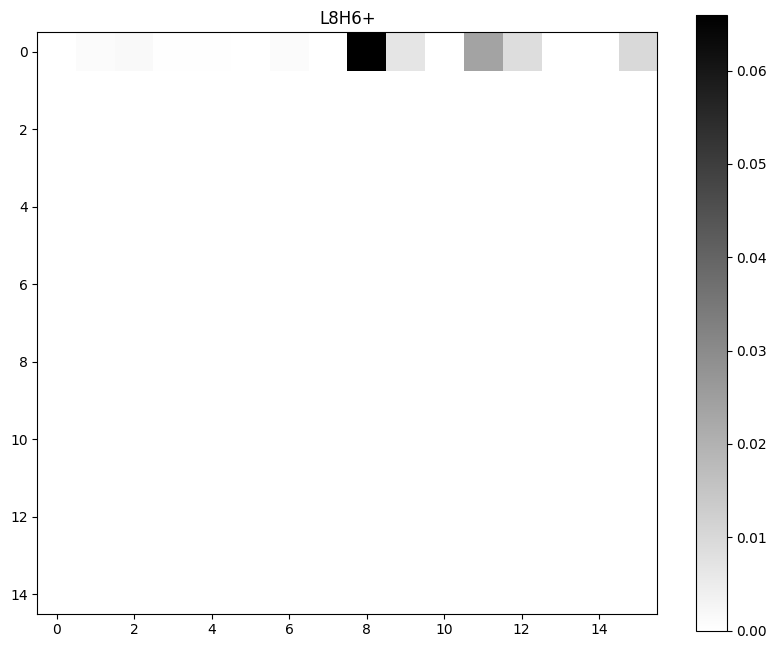

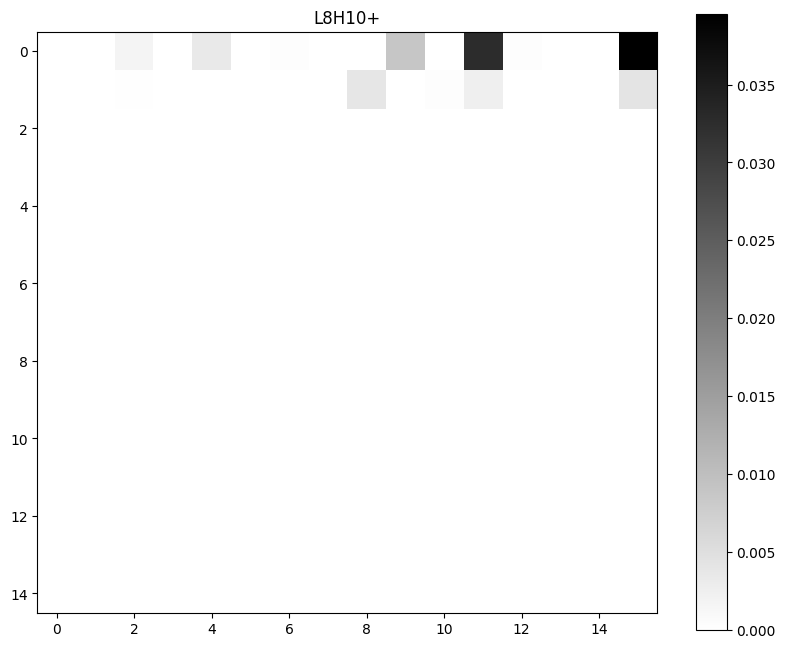

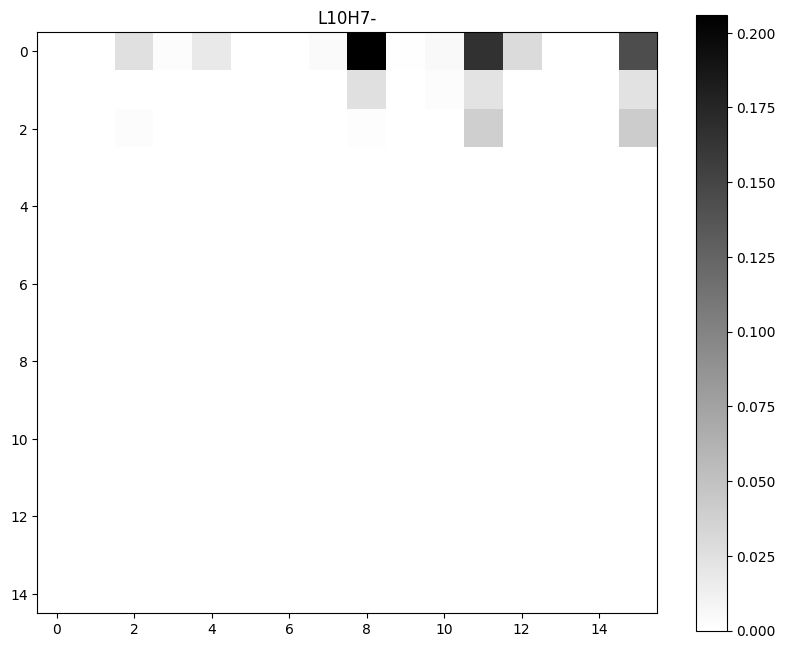

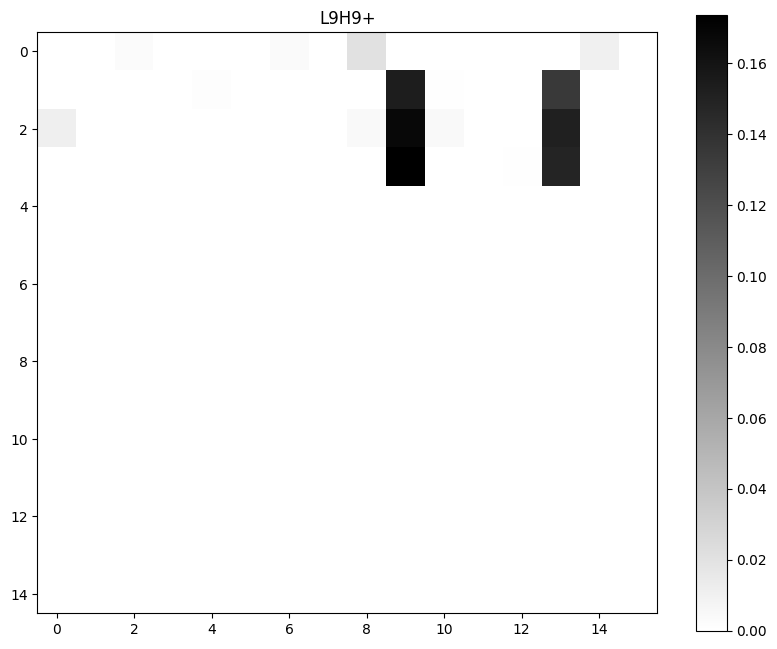

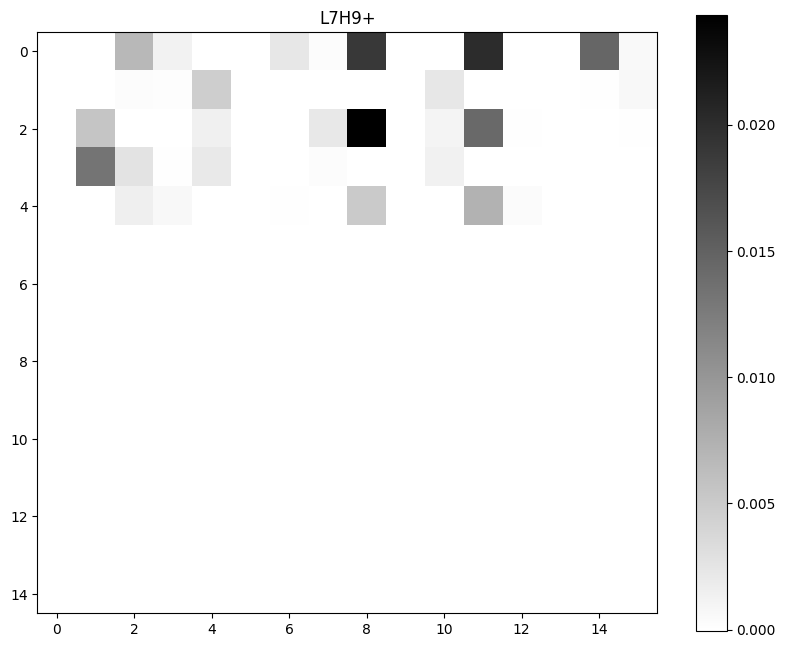

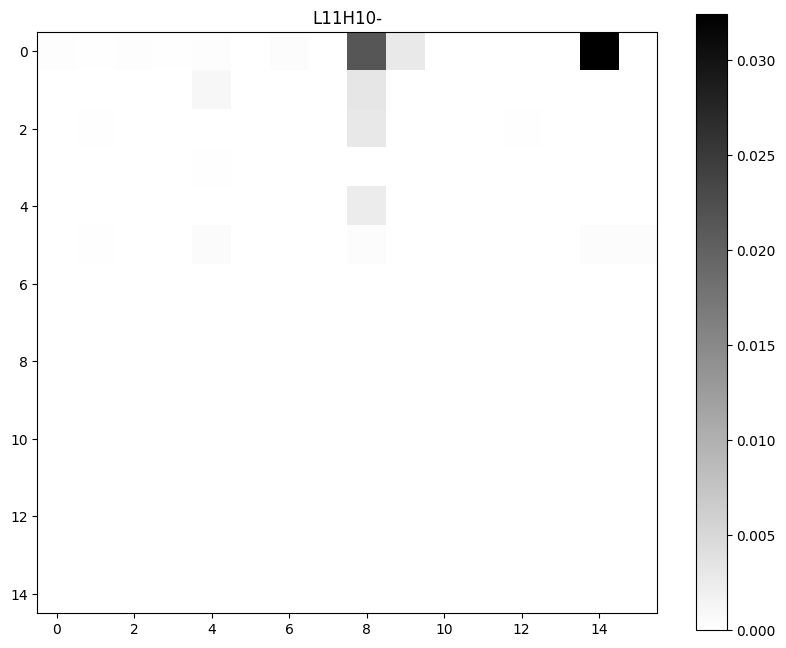

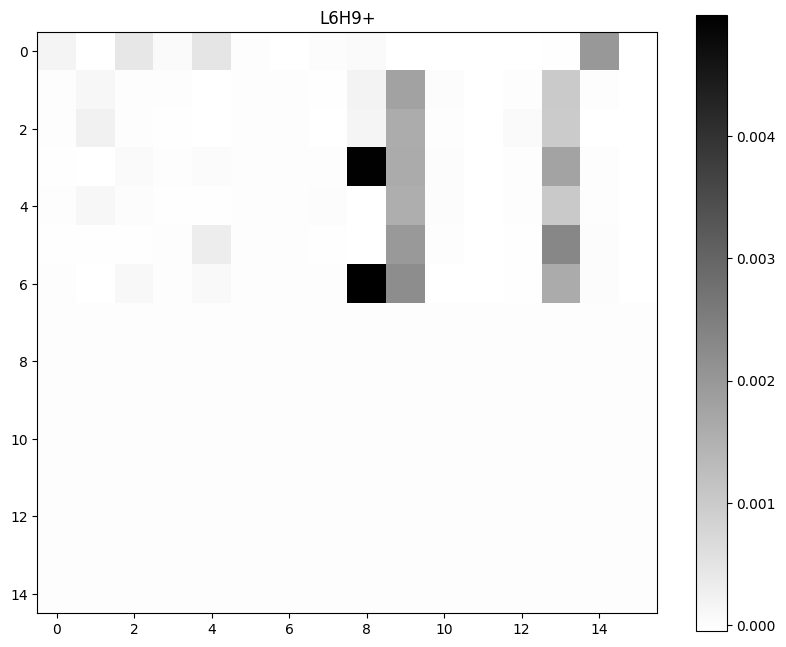

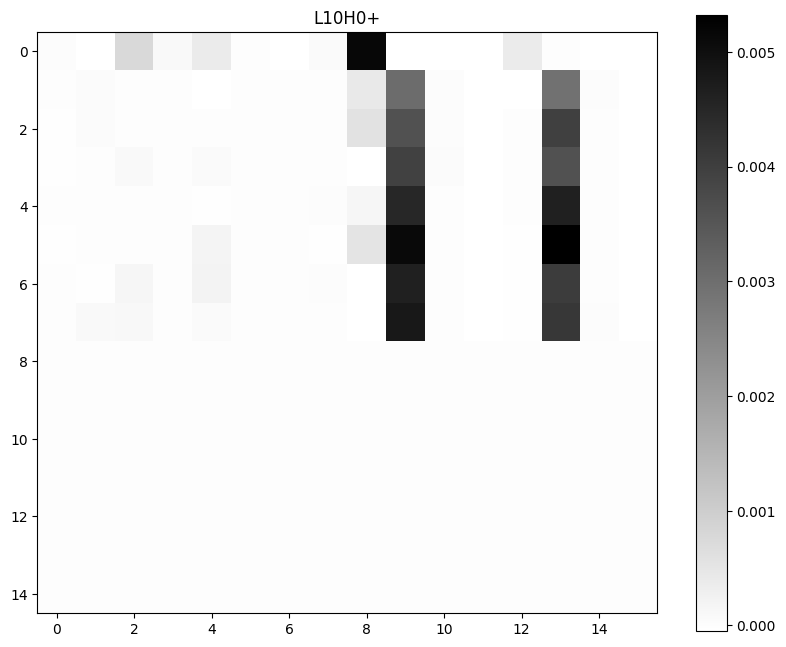

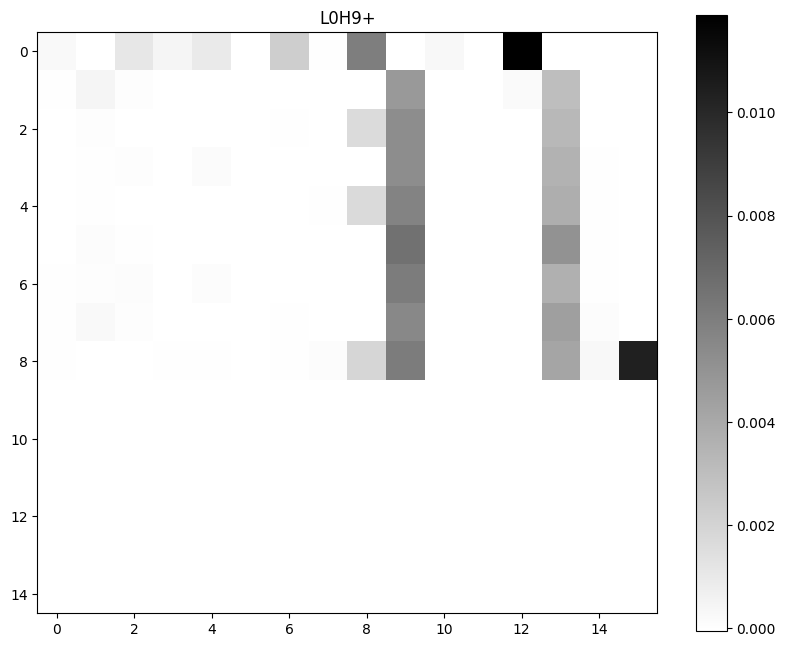

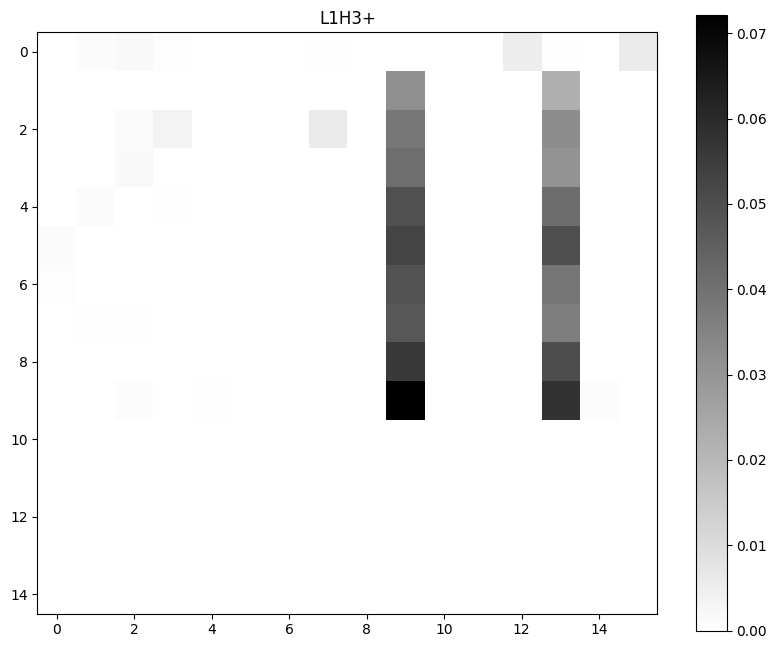

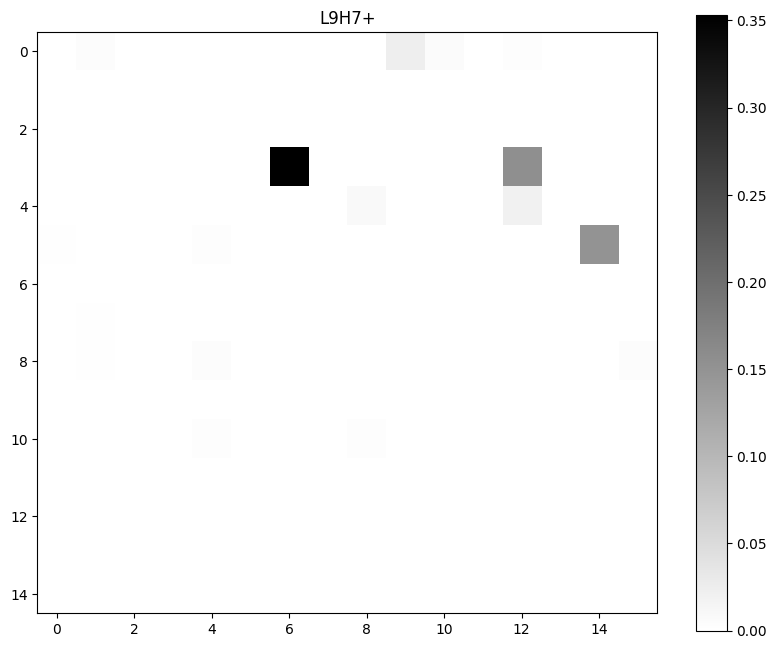

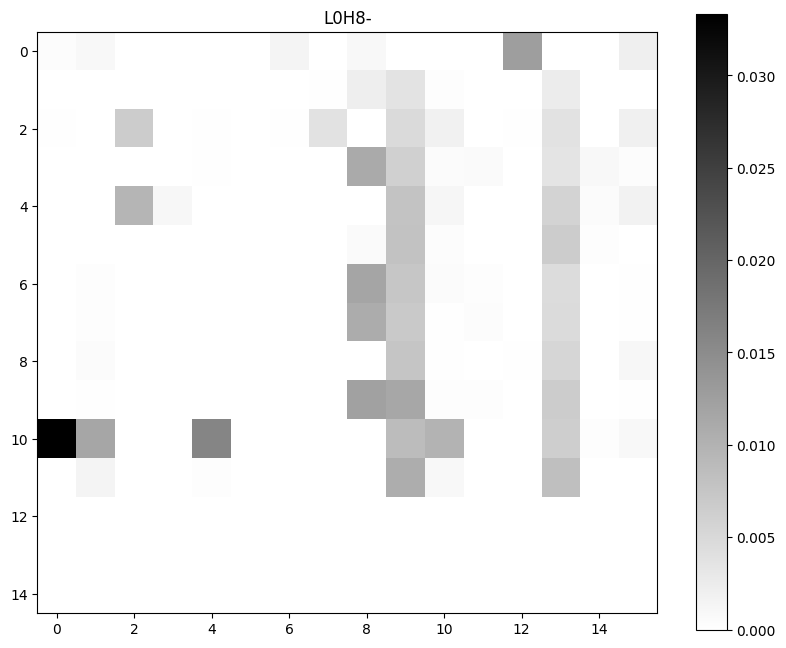

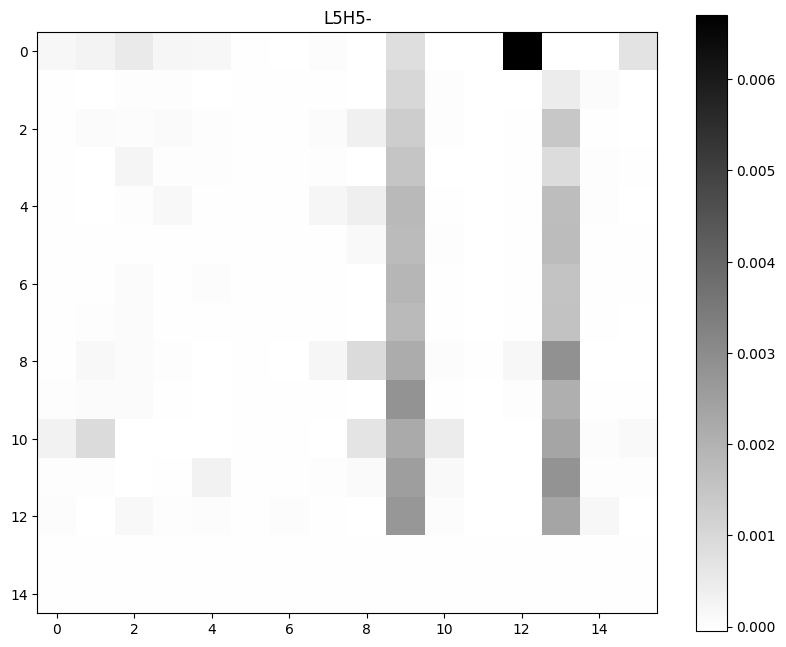

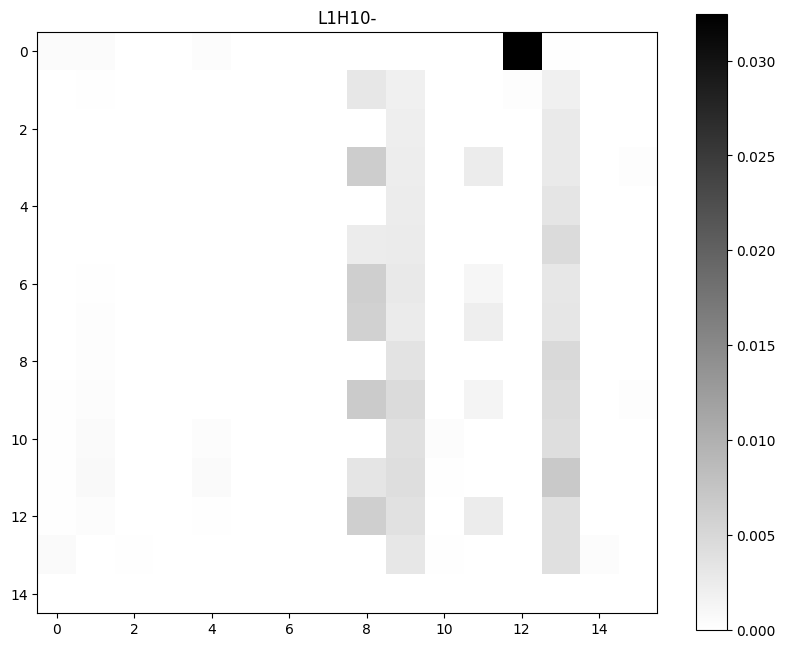

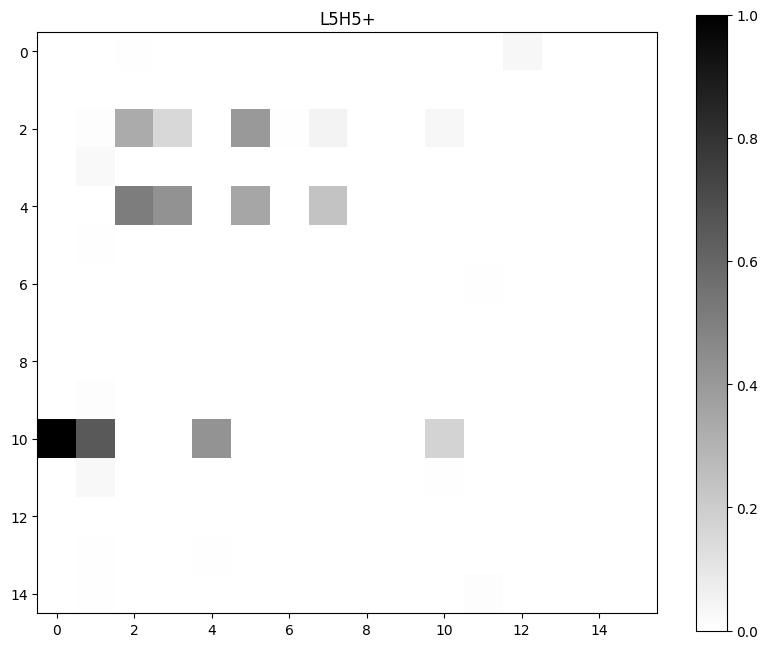

IndexError: index 15 is out of bounds for dimension 0 with size 15

In [ ]:
# TODO : viz corresponding to plot_attention_attr

import matplotlib.pyplot as plt
def plot_attention_attr(attention_attr, tokens, top_k=20, index=0, title=""):
    if len(tokens.shape) == 2:
        tokens = tokens[index]
    if len(attention_attr.shape) == 5:
        attention_attr = attention_attr[index]
    attention_attr_pos = attention_attr.clamp(min=-1e-5)
    attention_attr_neg = -attention_attr.clamp(max=1e-5)
    attention_attr_signed = torch.stack([attention_attr_pos, attention_attr_neg], dim=0)
    attention_attr_signed = einops.rearrange(
        attention_attr_signed,
        "sign layer head_index dest src -> (layer head_index sign) dest src",
    )
    attention_attr_signed = attention_attr_signed / attention_attr_signed.max()
    attention_attr_indices = (
        attention_attr_signed.max(-1).values.max(-1).values.argsort(descending=True)
    )
    # print(attention_attr_indices.shape)
    # print(attention_attr_indices)
    attention_attr_signed = attention_attr_signed[attention_attr_indices, :, :]
    head_labels = [HEAD_NAMES_SIGNED[i.item()] for i in attention_attr_indices]

    attentions = attention_attr_signed.permute(1, 2, 0)[:, :, :top_k]
    head_labels = head_labels[:top_k]

    for k in range(top_k):
      attn_map = attentions[k, :, :]
      label = head_labels[k]
      sequence_length = len(tokens)

      plt.figure(figsize=(10, 8))
      plt.title(label)
      plt.imshow(attn_map.detach().numpy(), cmap='binary', interpolation='nearest')


      plt.colorbar()
      plt.show()


plot_attention_attr(attention_attr.sum(0), clean_tokens[0], 16)


# Residual Stream Patching

In [ ]:
@timeit
def attr_patch_residual(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device,
) -> TT["component", "pos"]:
    clean_residual, residual_labels = clean_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=True
    )
    corrupted_residual = corrupted_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    corrupted_grad_residual = corrupted_grad_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    residual_attr = einops.reduce(
        corrupted_grad_residual * (clean_residual - corrupted_residual),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return residual_attr, residual_labels

In [ ]:
residual_attr, residual_labels = attr_patch_residual(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)
check_gpu_memory()

Function 'attr_patch_residual' executed in 0.0276 seconds
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


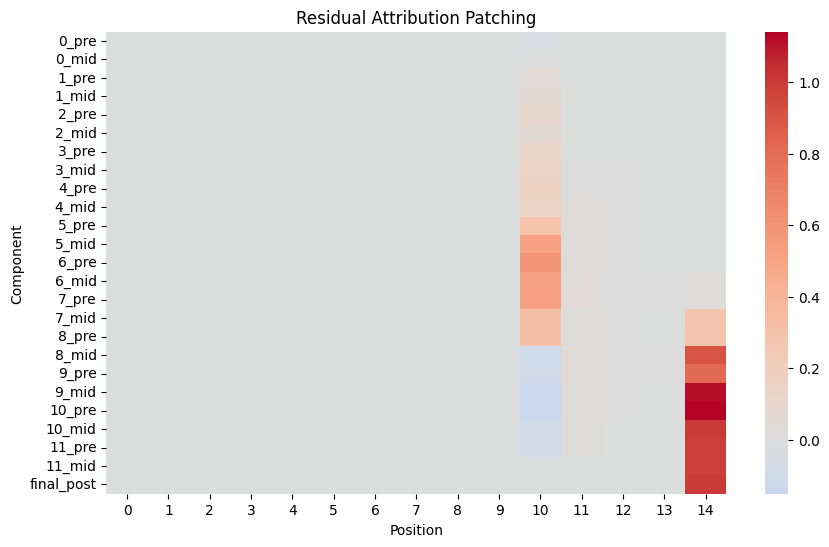

In [ ]:
# TODO : viz corresponding to attr_patch_residual
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(residual_attr.detach().numpy(), yticklabels=residual_labels, annot=False, cmap='coolwarm', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Residual Attribution Patching')
plt.show()

# Layer Output Attribution Patching

In [ ]:
@timeit
def attr_patch_layer_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    clean_layer_out, labels = clean_cache.decompose_resid(-1, return_labels=True)
    corrupted_layer_out = corrupted_cache.decompose_resid(-1, return_labels=False)
    corrupted_grad_layer_out = corrupted_grad_cache.decompose_resid(
        -1, return_labels=False
    )
    layer_out_attr = einops.reduce(
        corrupted_grad_layer_out * (clean_layer_out - corrupted_layer_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return layer_out_attr, labels

In [ ]:
layer_out_attr, layer_out_labels = attr_patch_layer_out(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)
check_gpu_memory()

Function 'attr_patch_layer_out' executed in 0.0320 seconds
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


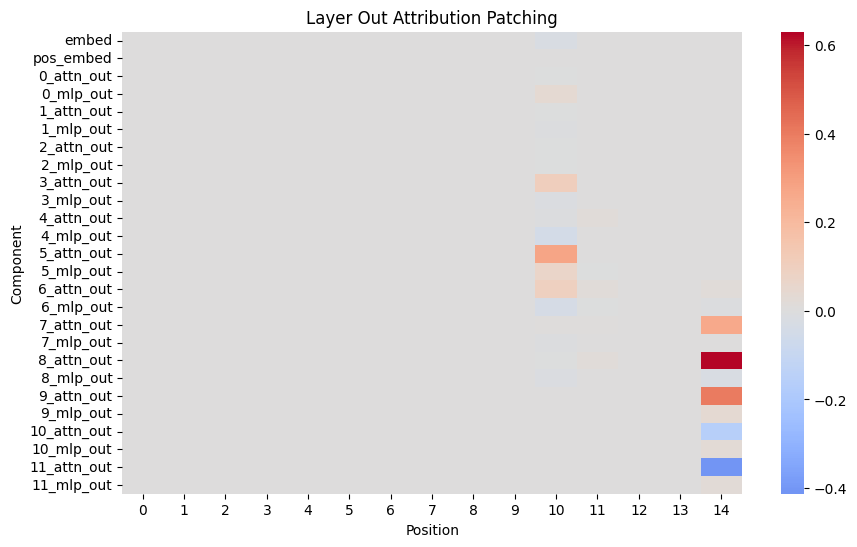

In [ ]:
# TODO : viz corresponding to attr_patch_layer_out
plt.figure(figsize=(10, 6))
sns.heatmap(layer_out_attr.detach().numpy(), yticklabels=layer_out_labels, annot=False, cmap='coolwarm', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Layer Out Attribution Patching')
plt.show()

# Head output attribution Patching

In [ ]:
@timeit
def attr_patch_head_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_out = clean_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_head_out = corrupted_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_grad_head_out = corrupted_grad_cache.stack_head_results(
        -1, return_labels=False
    ).to(device)
    head_out_attr = einops.reduce(
        corrupted_grad_head_out * (clean_head_out - corrupted_head_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return head_out_attr, labels

In [ ]:
head_out_attr, head_out_labels = attr_patch_head_out(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

sum_head_out_attr = einops.reduce(
    head_out_attr,
    "(layer head) pos -> layer head",
    "sum",
    layer=model.cfg.n_layers,
    head=model.cfg.n_heads,
)
check_gpu_memory()

Function 'attr_patch_head_out' executed in 0.1994 seconds
Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


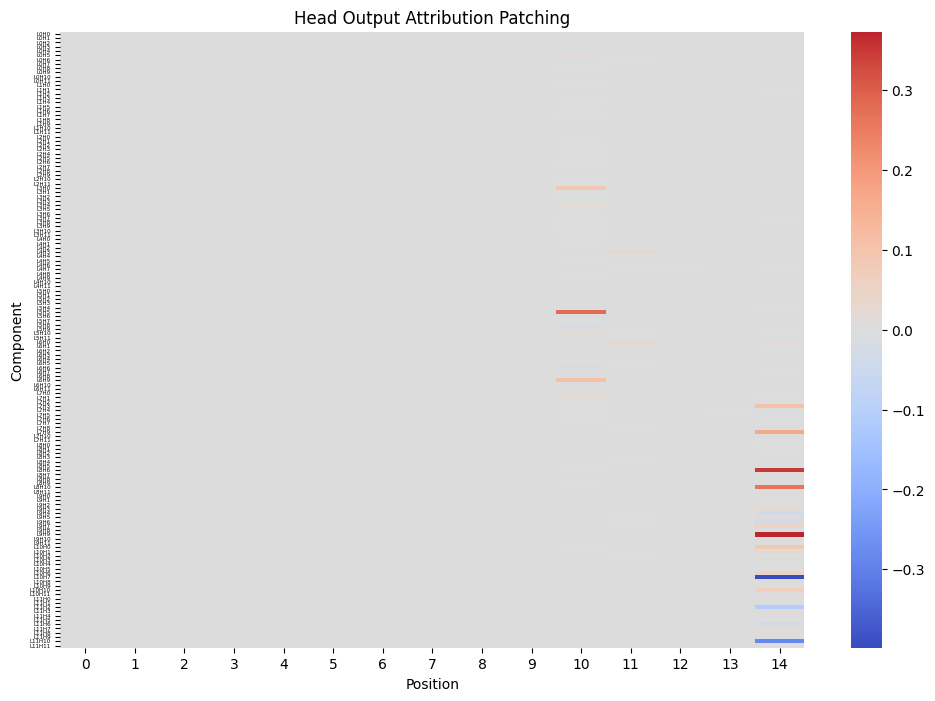

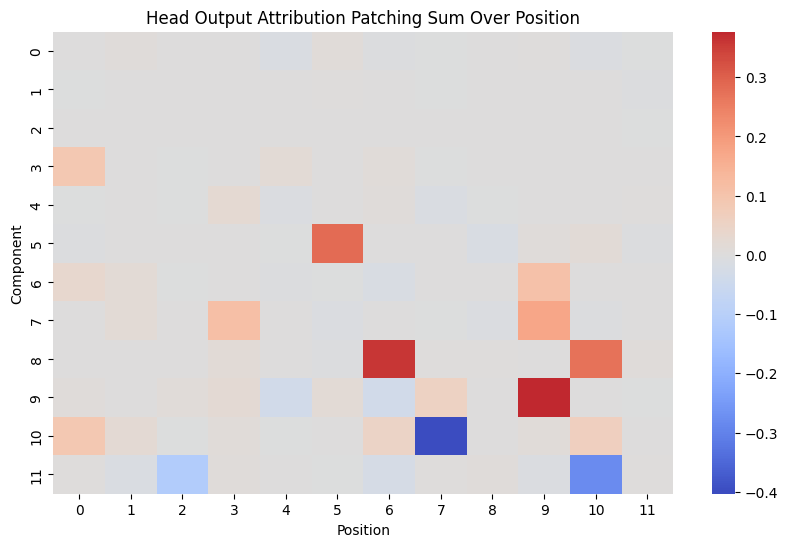

In [ ]:
# TODO : viz corresponding to attr_patch_head_out
plt.figure(figsize=(12, 8))
sns.heatmap(head_out_attr.detach().numpy(), yticklabels=head_out_labels, annot=False, cmap='coolwarm', center=0)
plt.yticks(fontsize = 4)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(sum_head_out_attr.detach().numpy(), annot=False, cmap='coolwarm', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching Sum Over Position')
plt.show()

# Head activation patching, skipping it for now

In [ ]:
def stack_head_vector_from_cache(
    cache, activation_name: Literal["q", "k", "v", "z"], device
) -> TT["layer_and_head_index", "batch", "pos", "d_head"]:
    """Stacks the head vectors from the cache from a specific activation (key, query, value or mixed_value (z)) into a single tensor."""
    stacked_head_vectors = torch.stack(
        [cache[activation_name, l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_vectors = einops.rearrange(
        stacked_head_vectors,
        "layer batch pos head_index d_head -> (layer head_index) batch pos d_head",
    ).to(device)
    return stacked_head_vectors

@timeit
def attr_patch_head_vector(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    activation_name: Literal["q", "k", "v", "z"],
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_vector = stack_head_vector_from_cache(clean_cache, activation_name, "cpu").to(device)
    corrupted_head_vector = stack_head_vector_from_cache(
        corrupted_cache, activation_name, "cpu"
    ).to(device)
    corrupted_grad_head_vector = stack_head_vector_from_cache(
        corrupted_grad_cache, activation_name, "cpu"
    ).to(device)
    head_vector_attr = einops.reduce(
        corrupted_grad_head_vector * (clean_head_vector - corrupted_head_vector),
        "component batch pos d_head -> component pos",
        "sum",
    )
    return head_vector_attr, labels

In [ ]:
head_vector_attr_dict = {}
for activation_name, activation_name_full in [
    ("k", "Key"),
    ("q", "Query"),
    ("v", "Value"),
    ("z", "Mixed Value"),
]:
    head_vector_attr_dict[activation_name], head_vector_labels = attr_patch_head_vector(
        clean_cache, corrupted_cache, corrupted_grad_cache, activation_name, "cpu"
    )
    sum_head_vector_attr = einops.reduce(
        head_vector_attr_dict[activation_name],
        "(layer head) pos -> layer head",
        "sum",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()

Function 'attr_patch_head_vector' executed in 0.0160 seconds
Function 'attr_patch_head_vector' executed in 0.0051 seconds
Function 'attr_patch_head_vector' executed in 0.0053 seconds
Function 'attr_patch_head_vector' executed in 0.0088 seconds
Primary device: cuda:0
GPU 0: 12207.00 MB  Allocated: 1276.02 MB  Reserved: 1740.00 MB


In [ ]:
# TODO : viz corresponding to attr_patch_head_vector

# Head Pattern Attribution Patching

In [ ]:
def stack_head_pattern_from_cache(
    cache,
    device
) -> TT["layer_and_head_index", "batch", "dest_pos", "src_pos"]:
    """Stacks the head patterns from the cache into a single tensor."""
    stacked_head_pattern = torch.stack(
        [cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_pattern = einops.rearrange(
        stacked_head_pattern,
        "layer batch head_index dest_pos src_pos -> (layer head_index) batch dest_pos src_pos",
    ).to(device)
    return stacked_head_pattern

@timeit
def attr_patch_head_pattern(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "dest_pos", "src_pos"]:
    labels = HEAD_NAMES

    clean_head_pattern = stack_head_pattern_from_cache(clean_cache, "cpu").to(device)
    corrupted_head_pattern = stack_head_pattern_from_cache(corrupted_cache, "cpu").to(device)
    corrupted_grad_head_pattern = stack_head_pattern_from_cache(corrupted_grad_cache, "cpu").to(device)
    head_pattern_attr = einops.reduce(
        corrupted_grad_head_pattern * (clean_head_pattern - corrupted_head_pattern),
        "component batch dest_pos src_pos -> component dest_pos src_pos",
        "sum",
    ).to(device)
    return head_pattern_attr, labels

In [ ]:
head_pattern_attr, labels = attr_patch_head_pattern(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

head_pattern_attr = einops.rearrange(
        head_pattern_attr,
        "(layer head) dest src -> layer head dest src",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()

Function 'attr_patch_head_pattern' executed in 0.0028 seconds
Primary device: cuda:0
GPU 0: 12207.00 MB  Allocated: 1276.02 MB  Reserved: 1740.00 MB


In [ ]:
# TODO : viz corresponding to attr_patch_head_pattern

# Head Path Attribution Patching

In [ ]:
def get_head_vector_grad_input_from_grad_cache(
    grad_cache: ActivationCache, activation_name: Literal["q", "k", "v"], layer: int, device
) -> TT["batch", "pos", "head_index", "d_model"]:
    vector_grad = grad_cache[activation_name, layer].to(device)
    ln_scales = grad_cache["scale", layer, "ln1"].to(device)
    attn_layer_object = model.blocks[layer].attn
    if activation_name == "q":
        W = attn_layer_object.W_Q.to(device)
    elif activation_name == "k":
        W = attn_layer_object.W_K.to(device)
    elif activation_name == "v":
        W = attn_layer_object.W_V.to(device)
    else:
        raise ValueError("Invalid activation name")

    # Original notebook used (batch pos) for second input but that seems to be wrong - double check this computation
    return einsum(
        "batch pos head_index d_head, batch pos head_index, head_index d_model d_head -> batch pos head_index d_model",
        vector_grad,
        ln_scales.squeeze(-1),
        W,
    )

def get_stacked_head_vector_grad_input(
    grad_cache, activation_name: Literal["q", "k", "v"], device
) -> TT["layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack(
        [
            get_head_vector_grad_input_from_grad_cache(grad_cache, activation_name, l, "cpu")
            for l in range(model.cfg.n_layers)
        ],
        dim=0,
    ).to(device)

def get_full_vector_grad_input(
    grad_cache, device
) -> TT["qkv", "layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack([get_stacked_head_vector_grad_input(grad_cache, activation_name, "cpu").to(device) for activation_name in ["q", "k", "v"]], dim=0).to(device)

@timeit
def attr_patch_head_path(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["qkv", "dest_component", "src_component", "pos"]:
    """
    Computes the attribution patch along the path between each pair of heads.

    Sets this to zero for the path from any late head to any early head

    """
    start_labels = HEAD_NAMES
    end_labels = HEAD_NAMES_QKV
    full_vector_grad_input = get_full_vector_grad_input(corrupted_grad_cache, "cpu")
    clean_head_result_stack = clean_cache.stack_head_results(-1)
    corrupted_head_result_stack = corrupted_cache.stack_head_results(-1)
    diff_head_result = einops.rearrange(
        clean_head_result_stack - corrupted_head_result_stack,
        "(layer head_index) batch pos d_model -> layer batch pos head_index d_model",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    path_attr = einsum(
        "qkv layer_end batch pos head_end d_model, layer_start batch pos head_start d_model -> qkv layer_end head_end layer_start head_start pos",
        full_vector_grad_input,
        diff_head_result,
    )
    correct_layer_order_mask = (
        torch.arange(model.cfg.n_layers)[None, :, None, None, None, None]
        > torch.arange(model.cfg.n_layers)[None, None, None, :, None, None]
    ).to(path_attr.device)
    zero = torch.zeros(1, device=path_attr.device)
    path_attr = torch.where(correct_layer_order_mask, path_attr, zero)

    path_attr = einops.rearrange(
        path_attr,
        "qkv layer_end head_end layer_start head_start pos -> (layer_end head_end qkv) (layer_start head_start) pos",
    )
    return path_attr, end_labels, start_labels


In [ ]:
head_path_attr, end_labels, start_labels = attr_patch_head_path(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

Function 'attr_patch_head_path' executed in 1.7312 seconds


In [ ]:
check_gpu_memory()

Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


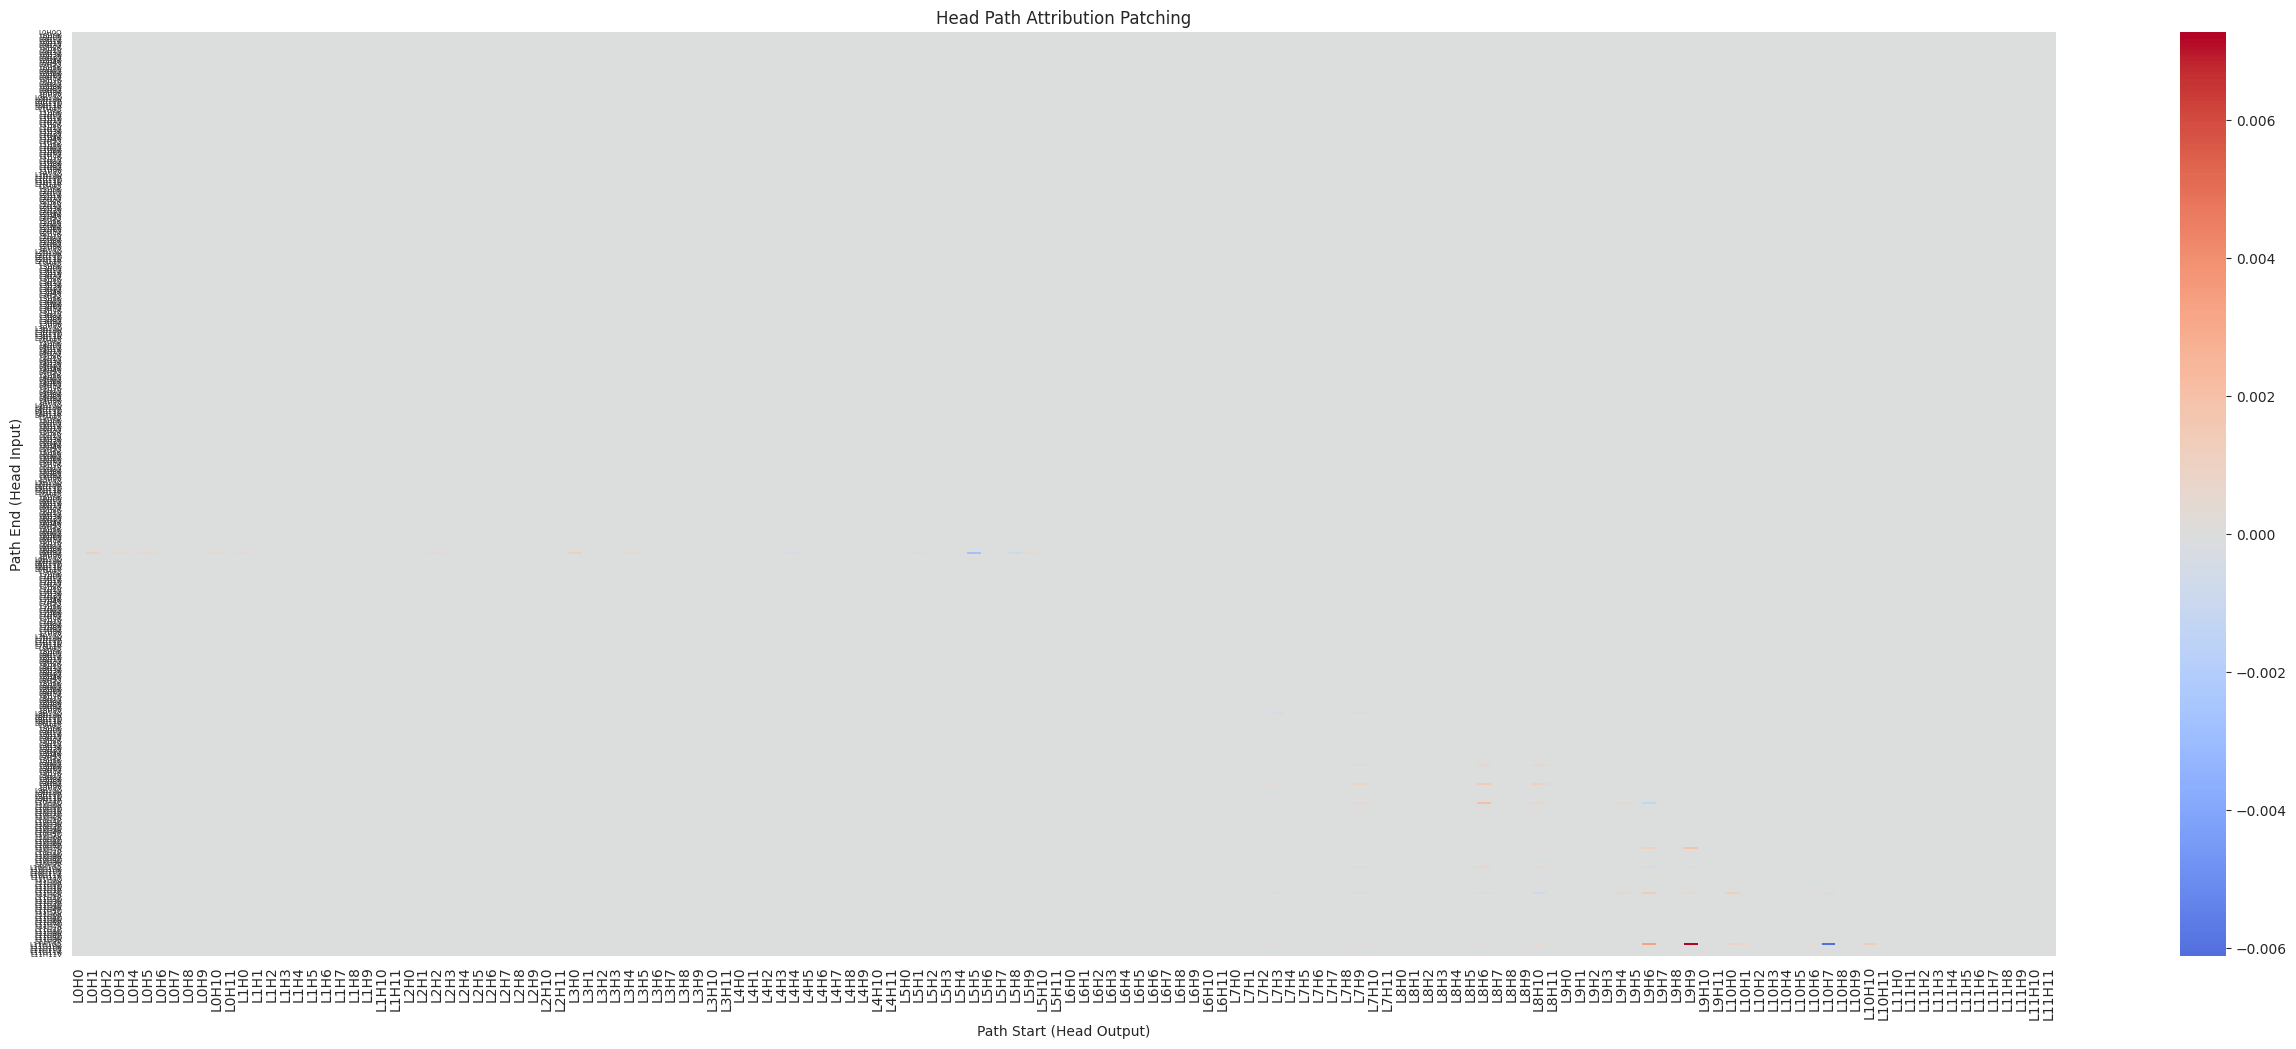

In [ ]:
# TODO : viz corresponding to attr_patch_head_path

plt.figure(figsize=(32, 12))
sns.set_style("white")
sns.heatmap(head_path_attr.sum(-1).detach().numpy(), yticklabels=end_labels, xticklabels = start_labels, annot=False, cmap='coolwarm', center=0)
plt.yticks(fontsize = 5)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
plt.show()

Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


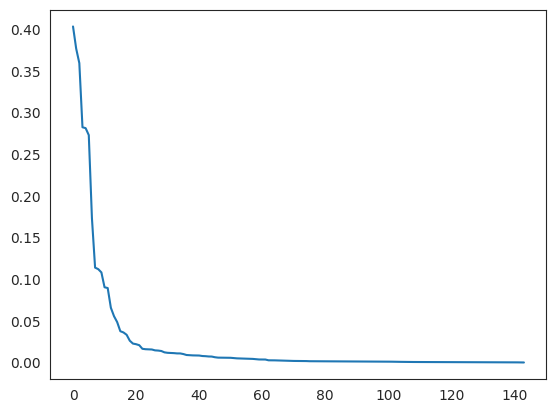

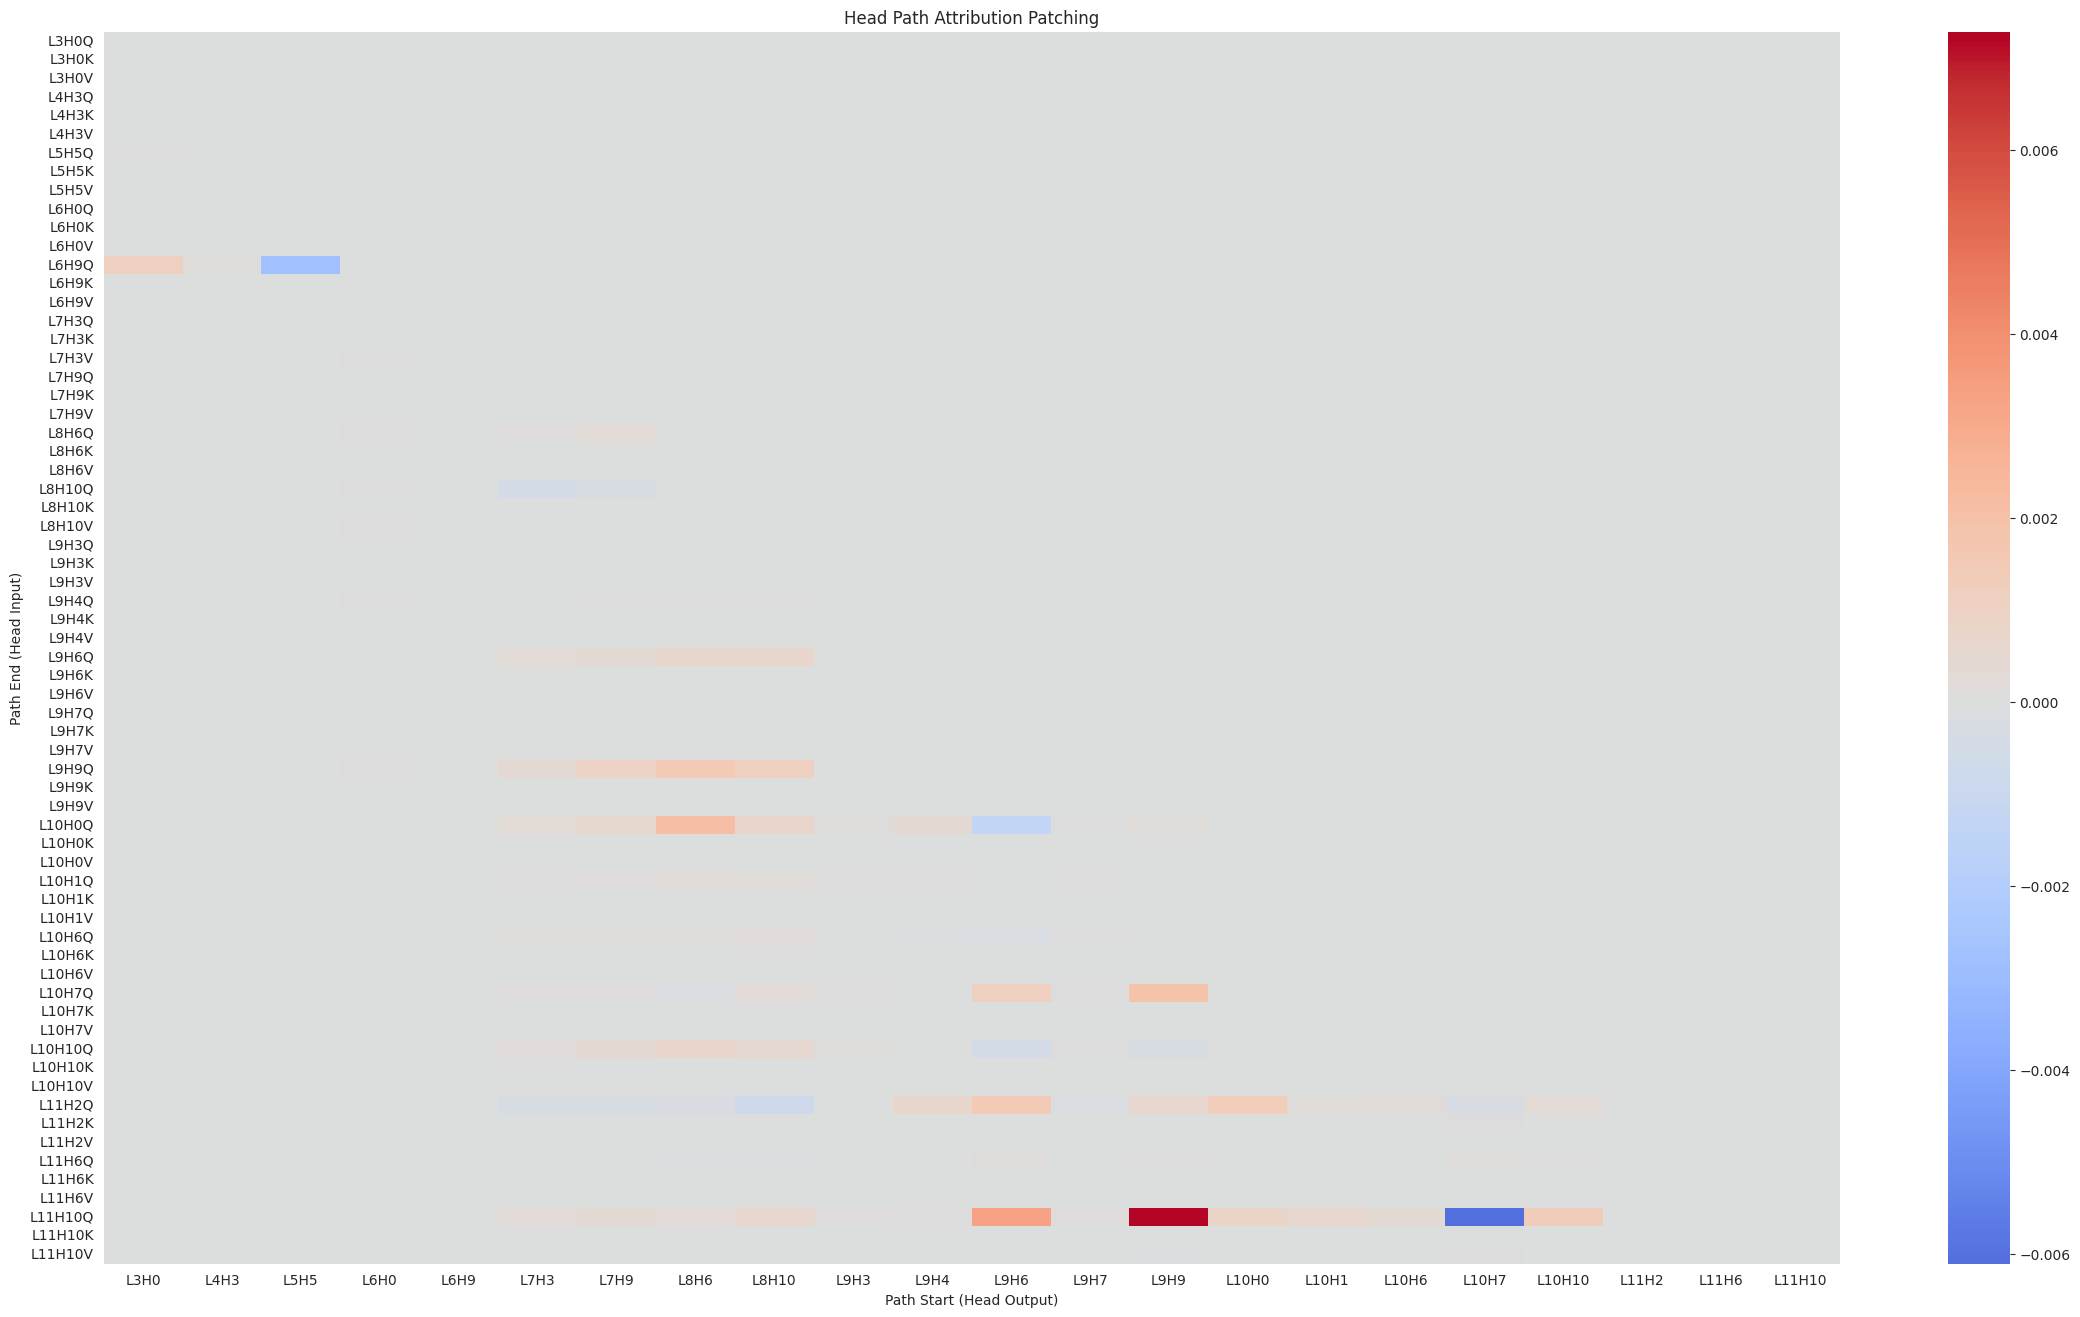

In [ ]:
head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:22].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

plt.plot(head_out_values.detach().numpy())

for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])

top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)

check_gpu_memory()

plt.figure(figsize=(28, 16))
sns.heatmap(head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1).detach().numpy(), yticklabels = top_end_labels, xticklabels= top_start_labels, annot=False, cmap='coolwarm', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
plt.show()

# TODO : viz corresponding to attr_patch_head_path

In [ ]:
# TODO : viz corresponding to attr_patch_head_path
# for j, composition_type in enumerate(["Query", "Key", "Value"]):
#     imshow(
#         head_path_attr[top_end_indices, :][:, top_start_indices][j::3].sum(-1),
#         y=top_end_labels[j::3],
#         yaxis="Path End (Head Input)",
#         x=top_start_labels,
#         xaxis="Path Start (Head Output)",
#         title=f"Head Path to {composition_type} Attribution Patching (Filtered for Top Heads)",
#     )

In [ ]:
top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)
# TODO : viz corresponding to attr_patch_head_path
# imshow(
#     top_head_path_attr,
#     y=[i[:-1] for i in top_end_labels[::3]],
#     yaxis="Path End (Head Input)",
#     x=top_start_labels,
#     xaxis="Path Start (Head Output)",
#     title=f"Head Path Attribution Patching (Filtered for Top Heads)",
#     facet_col=0,
#     facet_labels=["Query", "Key", "Value"],
# )

In [ ]:
interesting_heads = [
    5 * model.cfg.n_heads + 5,
    8 * model.cfg.n_heads + 6,
    9 * model.cfg.n_heads + 9,
]
interesting_head_labels = [HEAD_NAMES[i] for i in interesting_heads]
for head_index, label in zip(interesting_heads, interesting_head_labels):
    in_paths = head_path_attr[3 * head_index : 3 * head_index + 3].sum(-1)
    out_paths = head_path_attr[:, head_index].sum(-1)
    out_paths = einops.rearrange(out_paths, "(layer_head qkv) -> qkv layer_head", qkv=3)
    all_paths = torch.cat([in_paths, out_paths], dim=0)
    all_paths = einops.rearrange(
        all_paths,
        "path_type (layer head) -> path_type layer head",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
# TODO - implement visualization for input/output paths per head

check_gpu_memory()

Primary device: cuda:0
GPU 0: 12207.00 MB  Allocated: 1276.02 MB  Reserved: 1740.00 MB


# Validating Attribution vs Activation Patching

In [ ]:
attribution_cache_dict = {}
for key in corrupted_grad_cache.cache_dict.keys():
    attribution_cache_dict[key] = corrupted_grad_cache.cache_dict[key] * (
        clean_cache.cache_dict[key] - corrupted_cache.cache_dict[key]
    ).to("cpu")
attr_cache = ActivationCache(attribution_cache_dict, model).to("cpu")
check_gpu_memory()

Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


# Activation Patching per Block, skipping it for now

In [ ]:
device

'cuda:0'

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

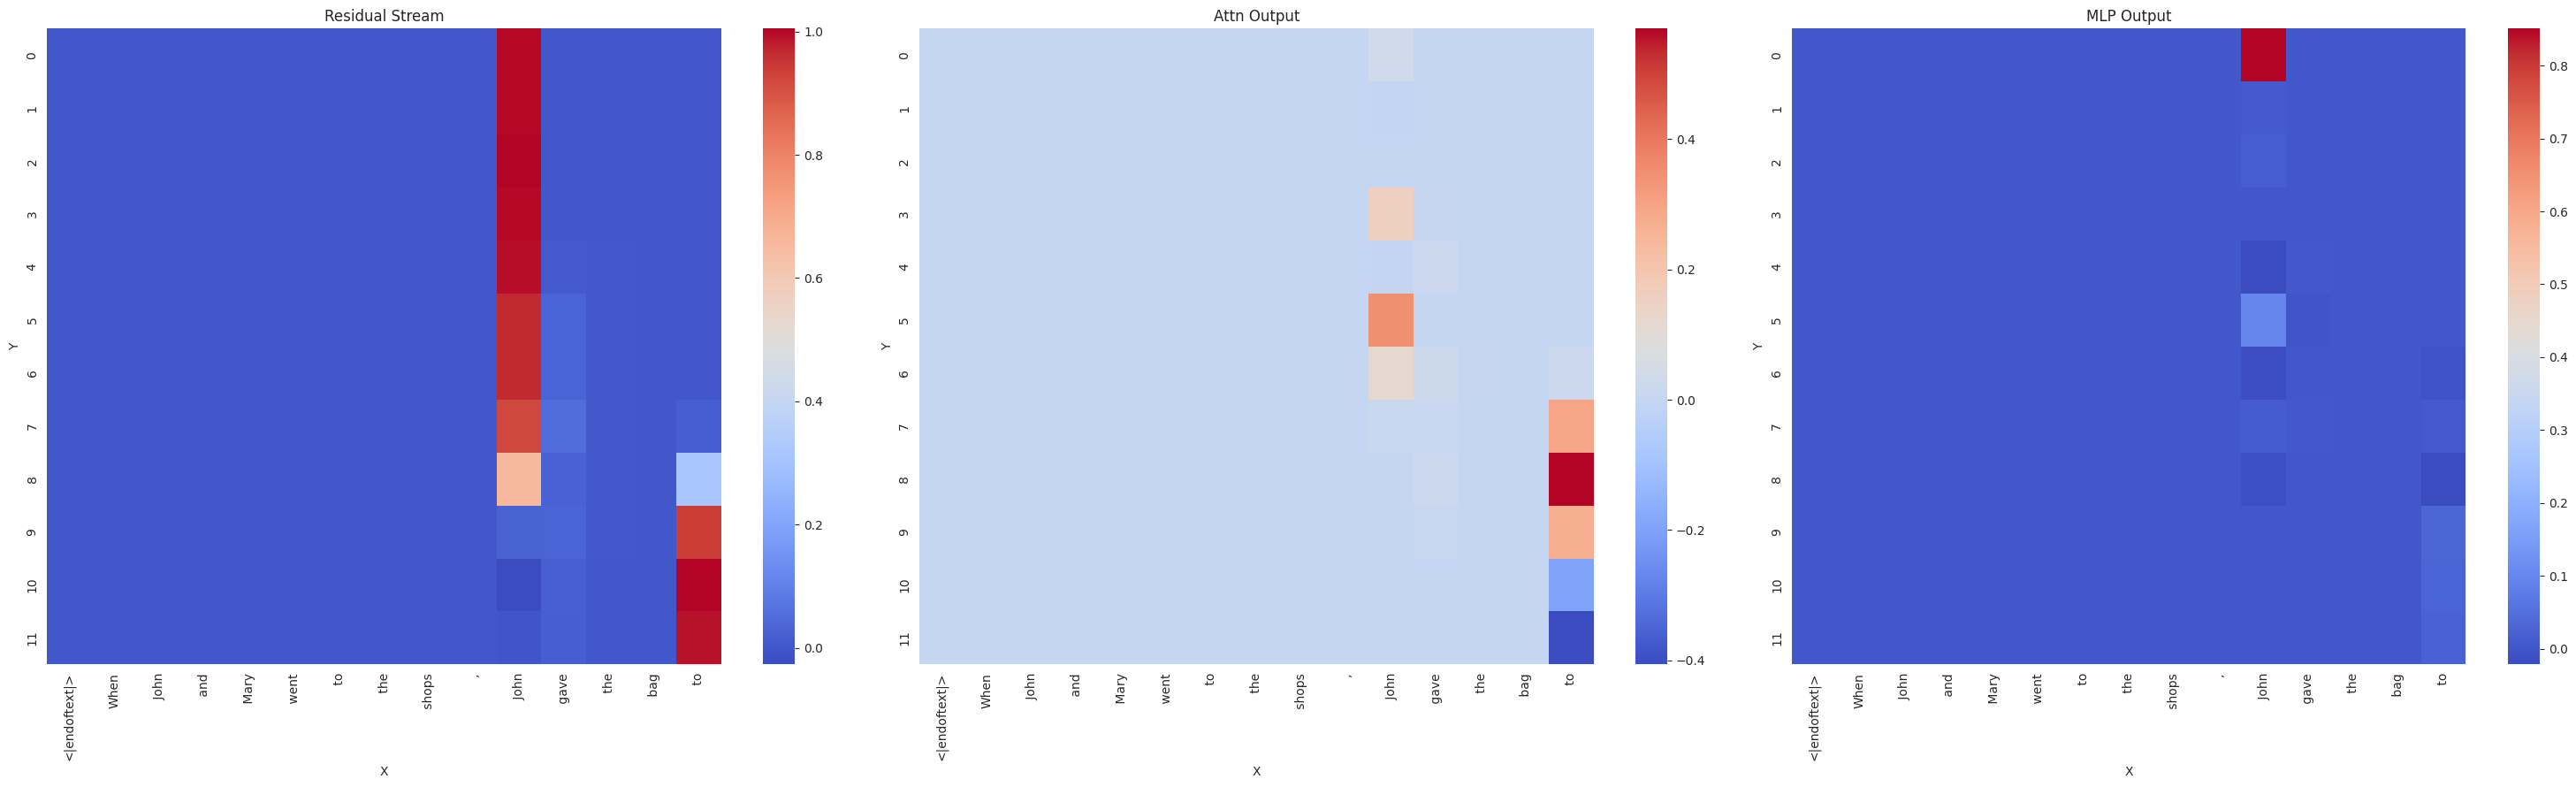

Primary device: cuda:0
GPU 0: 15102.06 MB  Allocated: 1283.52 MB  Reserved: 1718.00 MB


In [ ]:
str_tokens = model.to_str_tokens(clean_tokens[0])
context_length = len(str_tokens)
every_block_act_patch_result = patching.get_act_patch_block_every(
    model, corrupted_tokens, clean_cache, ioi_metric
).to("cpu")

fig, axs = plt.subplots(1,3, figsize=(30, 9))
facet_labels=["Residual Stream", "Attn Output", "MLP Output"]
for i in range(3):
    fig = sns.heatmap(every_block_act_patch_result.detach().numpy()[i], ax = axs[i], xticklabels= model.to_str_tokens(clean_tokens[0]), cmap='coolwarm')
    axs[i].set_title(facet_labels[i])
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')

plt.tight_layout()
plt.show()
# TODO : viz corresponding to Activation Patching per block
check_gpu_memory()

# Attribution Patching per Block

In [ ]:
@timeit
def get_attr_patch_block_every(attr_cache, device):
    resid_pre_attr = einops.reduce(
        attr_cache.stack_activation("resid_pre"),
        "layer batch pos d_model -> layer pos",
        "sum",
    ).to(device)
    attn_out_attr = einops.reduce(
        attr_cache.stack_activation("attn_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    ).to(device)
    mlp_out_attr = einops.reduce(
        attr_cache.stack_activation("mlp_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    ).to(device)

    every_block_attr_patch_result = torch.stack(
        [resid_pre_attr, attn_out_attr, mlp_out_attr], dim=0
    )
    return every_block_attr_patch_result

In [ ]:
every_block_attr_patch_result = get_attr_patch_block_every(attr_cache, "cpu")
check_gpu_memory()
# TODO : viz corresponding to Attribution Patching per block

Function 'get_attr_patch_block_every' executed in 0.0121 seconds
Primary device: cuda:0
GPU 0: 12207.00 MB  Allocated: 1276.02 MB  Reserved: 1740.00 MB


In [ ]:
# TODO : viz corresponding to Activation vs Attribution Patching per block

# Activation Patching per Head

In [ ]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

# # TODO : viz corresponding to Activation Patching per head

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

# Attribution Patching per Head

In [ ]:
@timeit
def get_attr_patch_attn_head_all_pos_every(attr_cache, device):
    head_out_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("z"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_q_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("q"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_k_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("k"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_v_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("v"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_pattern_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("pattern"),
        "layer batch head_index dest_pos src_pos -> layer head_index",
        "sum",
    )

    return torch.stack(
        [
            head_out_all_pos_attr,
            head_q_all_pos_attr,
            head_k_all_pos_attr,
            head_v_all_pos_attr,
            head_pattern_all_pos_attr,
        ]
    )


every_head_all_pos_attr_patch_result = get_attr_patch_attn_head_all_pos_every(
    attr_cache, "cpu"
)

# TODO : viz corresponding to Attribution Patching per block

Function 'get_attr_patch_attn_head_all_pos_every' executed in 0.0183 seconds


In [ ]:
# TODO : viz corresponding to Activation vs Attribution Patching per block

In [ ]:
# TODO : viz corresponding to Attention for specific heads
graph_tok_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
# imshow(
#     clean_cache["pattern", 5][:, 5],
#     x=graph_tok_labels,
#     y=graph_tok_labels,
#     facet_col=0,
#     title="Attention for Head L5H5",
#     facet_name="Prompt",
# )
# imshow(
#     clean_cache["pattern", 10][:, 7],
#     x=graph_tok_labels,
#     y=graph_tok_labels,
#     facet_col=0,
#     title="Attention for Head L10H7",
#     facet_name="Prompt",
# )
# imshow(
#     clean_cache["pattern", 11][:, 10],
#     x=graph_tok_labels,
#     y=graph_tok_labels,
#     facet_col=0,
#     title="Attention for Head L11H10",
#     facet_name="Prompt",
# )


In [ ]:
every_head_by_pos_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)
every_head_by_pos_act_patch_result = einops.rearrange(
    every_head_by_pos_act_patch_result,
    "act_type layer pos head -> act_type (layer head) pos",
)
# TODO : viz corresponding to Attention per head

In [ ]:
# TODO : viz corresponding to Attention for specific heads again
graph_tok_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
# imshow(
#     clean_cache["pattern", 5][:, 5],
#     x=graph_tok_labels,
#     y=graph_tok_labels,
#     facet_col=0,
#     title="Attention for Head L5H5",
#     facet_name="Prompt",
# )
# imshow(
#     clean_cache["pattern", 10][:, 7],
#     x=graph_tok_labels,
#     y=graph_tok_labels,
#     facet_col=0,
#     title="Attention for Head L10H7",
#     facet_name="Prompt",
# )
# imshow(
#     clean_cache["pattern", 11][:, 10],
#     x=graph_tok_labels,
#     y=graph_tok_labels,
#     facet_col=0,
#     title="Attention for Head L11H10",
#     facet_name="Prompt",
# )


# [markdown]

In [ ]:
# TODO : viz corresponding to Attention patching per head (by pos)

every_head_by_pos_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)
every_head_by_pos_act_patch_result = einops.rearrange(
    every_head_by_pos_act_patch_result,
    "act_type layer pos head -> act_type (layer head) pos",
)
imshow(
    every_head_by_pos_act_patch_result,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (By Pos)",
    xaxis="Position",
    yaxis="Layer & Head",
    zmax=1,
    zmin=-1,
    x=[f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
    y=head_out_labels,
)

In [ ]:
def get_attr_patch_attn_head_by_pos_every(attr_cache):
    head_out_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("z"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_q_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("q"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_k_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("k"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_v_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("v"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_pattern_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("pattern"),
        "layer batch head_index dest_pos src_pos -> layer dest_pos head_index",
        "sum",
    )

    return torch.stack(
        [
            head_out_by_pos_attr,
            head_q_by_pos_attr,
            head_k_by_pos_attr,
            head_v_by_pos_attr,
            head_pattern_by_pos_attr,
        ]
    )


every_head_by_pos_attr_patch_result = get_attr_patch_attn_head_by_pos_every(attr_cache)
every_head_by_pos_attr_patch_result = einops.rearrange(
    every_head_by_pos_attr_patch_result,
    "act_type layer pos head -> act_type (layer head) pos",
)
# TODO : viz corresponding to attribution patching per head (by pos)
# imshow(
#     every_head_by_pos_attr_patch_result,
#     facet_col=0,
#     facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
#     title="Attribution Patching Per Head (By Pos)",
#     xaxis="Position",
#     yaxis="Layer & Head",
#     zmax=1,
#     zmin=-1,
#     x=[f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
#     y=head_out_labels,
# )

In [ ]:
# TODO : viz corresponding to attribution vs Activation patching per head (by pos)